# Cross-validation for continuous structural parameter
Computation of a cross-validation score for different combinations of the number of features $N_f$ and the number of 
clusters $N_c$ used in adaptive kernel density estimation.

In [1]:
import numpy as np
from scipy import io
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import manifold
from adap_ks_evid_per import adap_ks_evid_per

In [2]:
# load traveltime data and (inverted) velocity data.
ttdata = np.load('ttdata_cont.npy')
veldata = np.load('veldata_cont.npy')
nsamps = np.size(ttdata, axis=0)
# load sampled values of orientation.
cp = np.load('cp.npy')
cpw = 2*cp # symmetry wrapping (to consider the periodic orientation)

In [3]:
# Insight-driven features

# Compute oriented averages
nbelec = 19 # number of electrodes in one borehole
orup = np.zeros([nbelec, nbelec])
uprec = np.zeros([nbelec, nbelec])
ordown = np.zeros([nbelec, nbelec])
downrec = np.zeros([nbelec, nbelec])
orav = np.zeros((nsamps, nbelec*2-1)) # substracting the zero-offset reciprocal
for r in range(nsamps):
    ttmat = np.reshape(ttdata[r,:], (38,19))
    for i in range(nbelec):
        for j in range(nbelec-i):
            orup[j,i] = ttmat[j,i+j]
            uprec[j,i] = ttmat[nbelec+i+j,j]
            ordown[j,i] = ttmat[i+j,j]
            downrec[j,i] = ttmat[nbelec+j,i+j]
            #print(nbelec+j+1,i+j+1)
        
    orup[orup==0.] = np.nan
    uprec[uprec==0.] = np.nan
    ordown[ordown==0.] = np.nan
    downrec[downrec==0.] = np.nan
    
    orav[r,0] = np.sum(orup[:,0] + uprec[:,0])/(nbelec*2)
    for i in range(nbelec-1):
        orav[r,i+1] = np.nansum(orup[:,i+1] + uprec[:,i+1])/(nbelec*2-(i+1)*2)
        orav[r,nbelec+i] = np.nansum(ordown[:,i+1] + downrec[:,i+1])/(nbelec*2-(i+1)*2)

# Build arrays (images) of the inverted velocities.
velimag = np.zeros((49,24,nsamps))
for i in range(nsamps):
    velimag[:,:,i] = veldata[i,:].reshape(49,24)
    
# Radon transform on inverted velocities
from skimage.transform import radon
theta = [0,30,45,60,90,120,135,150]
ntheta = len(theta)
#ntheta= 180
sinogram = np.zeros((70,ntheta,nsamps))
for i in range(nsamps):
    sinogram[:,:,i] = radon(velimag[:,:,i], theta=theta, circle=False)
    
sinogramc = np.zeros((nsamps,70*ntheta))
for i in range(nsamps):
    sinogramc[i,:] = np.reshape(sinogram[:,:,i], (70*ntheta))

In [4]:
# initialize cross-validation matrix.
ndims = 10
nclus = 15
avprob = np.zeros((nclus-1,ndims)) # (nclus-1) is because we start with two clusters (K=2)
logprob = np.zeros((nclus-1,ndims))

In [5]:
# iterate over the cross-validation combinations (may take a while).
# uncomment/comment each of the 6 'blocks' to compute the CV matrix for the corresponding method.
for j in range(ndims):

    try:
        textmeth = 'PCA_t'
        dim = j+1
        mypca = PCA(n_components=dim, random_state=5894)
        lowdim = mypca.fit_transform(ttdata)
        
#        textmeth = 'MDS_t'
#        dim=j+1
#        mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
#        lowdim = mymds.fit_transform(veldata) # change veldata/ttdata
        
#        textmeth = 'PCA_a'
#        dim = j+1
#        mypca = PCA(n_components=dim, random_state=5894, n_init=20)
#        lowdim = mypca.fit_transform(orav)

#        textmeth = 'MDS_a'
#        dim = j+1
#        mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
#        lowdim = mymds.fit_transform(orav)

#        textmeth = 'MDS_v'
#        dim = j+1
#        mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
#        lowdim = mymds.fit_transform(veldata)
        
#        textmeth = 'MDS_R'
#        dim = j+1
#        mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
#        lowdim = mymds.fit_transform(sinogramc)
    
        fac = np.std(cpw)/np.max(np.std(lowdim, axis=0))
        lowdimp = np.column_stack([fac*lowdim,cpw])
        dimp = dim + 1
        
        for l in range(nclus-1):
            
            K = l+2
            updens = np.zeros(nsamps)
            upevid = np.zeros(nsamps)
            upmean = np.zeros(nsamps)
            #upentro = np.zeros(nsamps)
            for obs_pos in range(nsamps):   
                q = np.zeros([1,dimp])
                q[0,:dim], q[0,dim] = lowdimp[obs_pos,:dim], cpw[obs_pos,0] # set observation position
                    
                # take out observation for kernel density estimation
                lowdimpdum = np.concatenate((lowdimp[:obs_pos,:], lowdimp[obs_pos+1:,:]), axis=0)
                obs = q
                updens[obs_pos], upevid[obs_pos], kclus, upmean[obs_pos] = adap_ks_evid_per(lowdimpdum, dimp, K, obs)
            
            upprob = updens/upevid
            avprob[l,j] = np.average(upprob)
            logprob[l,j] = np.average(np.log(upprob))

        print('score computed for N_f=%i and N_C=%i'%(j+1,K))
    except:
        pass

score computed for N_f=1 and N_C=15
score computed for N_f=2 and N_C=15
score computed for N_f=3 and N_C=15
score computed for N_f=4 and N_C=15
score computed for N_f=5 and N_C=15
score computed for N_f=6 and N_C=15
score computed for N_f=7 and N_C=15
score computed for N_f=8 and N_C=15
score computed for N_f=9 and N_C=15
score computed for N_f=10 and N_C=15


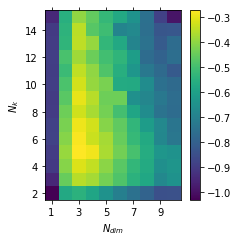

In [6]:
# Plotting the cross-validation matrix

# In case the AKDE computes a bandwidth of zero, the KDE estimation is not defined, then to plot we set:
logprob[logprob==0.0] = np.nan

fig, ax = plt.subplots()
fig.set_size_inches(3.5,3.5)
cb = ax.matshow(logprob, origin='lower')
ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(1,11,2))
ax.set_yticks(np.arange(0,14,2))
ax.set_yticklabels(np.arange(2,16,2))
ax.tick_params(labelbottom=True, labeltop=False, axis='x')
ax.set_xlabel(r'$N_{dim}$')
ax.set_ylabel(r'$N_k$')
fig.colorbar(cb, orientation='vertical', fraction=.1)

In [7]:
indmax = np.unravel_index(np.nanargmax(logprob, axis=None), logprob.shape)
print('maximum logprob score is for N_f=%i and N_k=%i'%(indmax[1]+1,indmax[0]+2))

maximum logprob score is for N_f=3 and N_k=5
